<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
push!(LOAD_PATH, ".")
using RobustOptimization
using Ipopt, JuMP, PyPlot
using ScikitLearn
@sk_import model_selection: train_test_split
@sk_import metrics: roc_curve
@sk_import metrics: roc_auc_score
@sk_import metrics: accuracy_score
@sk_import metrics: classification_report
path_train = "datasets/colon-cancer"
nbfeatures = 2000
data_train = read_data_libsvm(path_train, nbfeatures);
# xtr, xte, ytr, yte = train_test_split(data_train[:,1:end-1], data_train[:,end], train_size = 0.15)
# ab_train = hcat(xtr, ytr)
# aux_train = ab_train[ab_train[:,end] .< 0,:]
# ll_train = vcat(aux_train,data_train[data_train[:,end].>0,:])

xtr, xte, ytr, yte = train_test_split(data_train[:,1:end-1], data_train[:,end], train_size = 0.6)
df_train = hcat(xtr, ytr)
df_aux= hcat(xte, yte);

In [2]:
# df_train, df_aux = create_data("diabetes_scale", nbfeatures, 0.2, train_test_split)
solver = IpoptSolver(print_level = 2)
N = size(df_train)[1]
ϵ = 0.05
verbosity = 1
itmax = 100
sample = 10

ambiguity = "KLdivergence"
robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
α = 1/norm(robustModel.descent_direction)
# α = 0.1
projParams = ProjParams(Int(40), 1e-5, sample, para_proj=Sequential(), para_inter=Sequential())
optParams = OptParams(itmax, 1e-5, α, verbosity = verbosity);

In [3]:
# Séparer à la main entre label 1 et 0 et regarder les fréquences de chacun
# Fraude bancaire avec faux positifs
# Avec erreur de 0.01% changer le label. Mislabelled training dataset (regarder papier sur le sujet)

In [4]:
xnormal = normal_opt(df_train, solver, robustModel.regressionModel)
fpr, tpr, thresholds = roc_curve(df_aux[:,end], positive_rate(xnormal,df_aux))
print(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

0.8897058823529411  0.68


In [27]:
e_tab = [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.05,0.1,0.5,1.0]

14-element Array{Float64,1}:
 0.001
 0.002
 0.003
 0.004
 0.005
 0.006
 0.007
 0.008
 0.009
 0.01 
 0.05 
 0.1  
 0.5  
 1.0  

In [6]:
dm_tab = []
xr1_tab = []
xr2_tab = []
fpr1_tab = []
tpr1_tab = []
fpr2_tab = []
tpr2_tab = []
# for ϵ in e_tab
for ϵ in [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.05,0.1,0.5,1.0]
    println(" ")
    println("espilon = ", ϵ)
    println(" ")
    robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
    x0 = initialize(df_train, robustModel, KLConstraint())
    xalg, yalg, dm, mem, mini = run_algo(x0, df_train, robustModel, optParams, projParams)
    xrobust1 = getsolution(xalg, ambiguity, nbfeatures)
    xrobust2 = getsolution(mem, ambiguity, nbfeatures)
    fpr1, tpr1, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust1,df_aux))
    fpr2, tpr2, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust2,df_aux))
    push!(dm_tab, dm)
    push!(xr1_tab, xrobust1)
    push!(xr2_tab, xrobust2)
    push!(fpr1_tab, fpr1)
    push!(tpr1_tab, tpr1)
    push!(fpr2_tab, fpr2)
    push!(tpr2_tab, tpr2)
end

 
espilon = 0.001
 
1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.34391284225425683 23 0.0 24 0.0 25 0.0 26 0.0 27 0.4265864523699782 28 0.6075827505361007 29 0.6600299113974428 30 0.016829458177142764 31 0.09217320445959265 32 0.12768694809987347 33 0.06706753133114739 34 0.36614556152708455 35 0.07339066693670371 36 0.9179345721075192 37 0.20502169898979447 38 0.7030831907500479 39 0.1458108435682961 40 0.6825531036617795 41 0.17235794020205128 42 0.019691081730203064 43 0.07167922385916697 44 0.01041253943107745 45 0.0051499703307270606 46 0.008194096066532652 47 0.008911623751110875 48 0.006264296188212226 49 0.014666680491220885 50 0.008915639529386454 51 0.0031976662949873003 52 0.003240020505817176 53 0.004005167487892258 54 0.0031363560036260507 55 0.0027326959583552357 56 0.004358512614568322 57 0.00442181919421103 58 0.002621811000037444 59 0.0036253253597671176 60 0.0028373281831

1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 3.203613672501213 17 0.0 18 0.0 19 0.0 20 0.024096199184369227 21 0.0 22 348.35381550699816 23 0.0 24 0.02155106435124382 25 0.02040390642993306 26 0.0 27 0.0 28 0.0 29 0.0 30 0.01833701375379948 31 0.07191126902838318 32 0.20714619857335886 33 0.5107831142966326 34 0.1878472859040288 35 8.568265265185282e-6 36 0.10948483958816835 37 0.0639711063876589 38 0.26755225254857284 39 0.033678520546800095 40 0.05516883164174576 41 0.15843461653788715 42 0.3103792980700061 43 0.01693551188533582 44 0.1286550764804847 45 0.37294230826233593 46 0.04144662507573149 47 0.06392832432050796 48 0.021247917924708037 49 0.01274880599924505 50 0.005980935781113583 51 0.0026466285299828196 52 0.004410844665886482 53 0.00454903574734955 54 0.007315539960952133 55 0.006721971076893762 56 0.004780650173934142 57 0.0035405760339144443 58 0.004596341137523496 59 0.004177645749248504 60 0.006767522381908031 61 0.

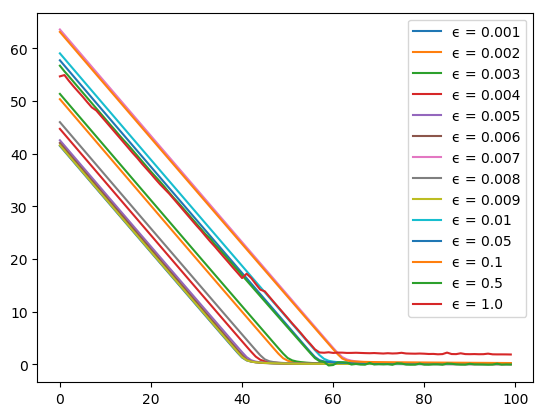

PyObject <matplotlib.legend.Legend object at 0x7f4f5d9707f0>

In [28]:
for i in 1:14
     plot(dm_tab[i], label="ϵ = $(e_tab[i])")
end
legend()

In [12]:
plot(fpr,tpr, color="black", label="LR")
for i in 1:14
     plot(fpr1_tab[i], tpr1_tab[i], label="ϵ = $(e_tab[i])")
end
legend()

LoadError: [91mUndefVarError: e_tab not defined[39m

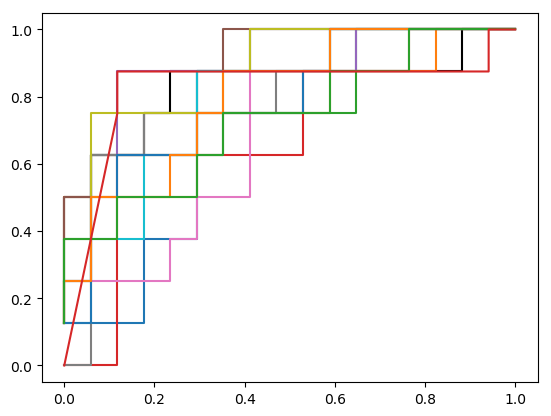

In [30]:
plot(fpr,tpr, color="black")
for i in 1:14
     plot(fpr2_tab[i], tpr2_tab[i])
end

In [31]:
print(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
for i in 1:14
    print(roc_auc_score(df_aux[:,end], positive_rate(xr1_tab[i],df_aux)))
    print("  ")
    println(accuracy_score(df_aux[:,end], pred(df_aux, xr1_tab[i], LogisticRegression())))
end

0.8308823529411764  0.64
0.7573529411764706  0.68
0.75  0.64
0.7794117647058824  0.64
0.6985294117647058  0.6
0.8676470588235294  0.68
0.8897058823529411  0.76
0.7279411764705883  0.72
0.8088235294117647  0.68
0.875  0.72
0.8014705882352942  0.72
0.7867647058823529  0.68
0.8014705882352942  0.6
0.7426470588235294  0.68
0.8235294117647058  0.84


In [32]:
print(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
for i in 1:14
    print(roc_auc_score(df_aux[:,end], positive_rate(xr2_tab[i],df_aux)))
    print("  ")
    println(accuracy_score(df_aux[:,end], pred(df_aux, xr2_tab[i], LogisticRegression())))
end

0.8308823529411764  0.64
0.7573529411764706  0.68
0.75  0.64
0.7794117647058824  0.64
0.6985294117647058  0.6
0.8676470588235294  0.68
0.8897058823529411  0.76
0.7279411764705883  0.72
0.8088235294117647  0.68
0.875  0.72
0.8014705882352942  0.72
0.7867647058823529  0.68
0.8014705882352942  0.6
0.7352941176470589  0.68
0.8235294117647058  0.84


In [12]:
# @everywhere df_train, df_aux = create_data("diabetes_scale", nbfeatures, 0.7, train_test_split)
# @everywhere solver = IpoptSolver(print_level = 2)
N = size(df_train)[1]
# @everywhere ϵ = 0.05
verbosity = 1
itmax = 50
sample = 410

ambiguity = "wasserstein"
robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
α = 1/norm(robustModel.descent_direction)
# @everywhere α = 1.0
projParams = ProjParams(Int(20), 1e-5, sample, para_proj=Sequential(), para_inter=Sequential())
optParams = OptParams(itmax, 1e-5, α, verbosity = verbosity);

In [13]:
# xnormal = normal_opt(df_train, solver, robustModel.regressionModel)
# fpr, tpr, thresholds = roc_curve(df_aux[:,end], positive_rate(xnormal,df_aux))

In [35]:
e_was = [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.02,0.03,0.04,
        0.05,0.06,0.07,0.08,0.09,0.1,0.5,1.0];

In [36]:
dm_was = []
xr1_was = []
xr2_was = []
fpr1_was = []
tpr1_was = []
fpr2_was = []
tpr2_was = []
# for ϵ in [0.05,0.1]
for ϵ in e_was
    println(" ")
    println("espilon = ", ϵ)
    println(" ")
    robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
    x0 = init_proj(df_train, robustModel, projParams);
    xalg, yalg, dm, mem, mini = run_algo(x0, df_train, robustModel, optParams, projParams)
    xrobust1 = getsolution(xalg, ambiguity, nbfeatures)
    xrobust2 = getsolution(mem, ambiguity, nbfeatures)
    fpr1, tpr1, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust1,df_aux))
    fpr2, tpr2, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust2,df_aux))
    push!(dm_was, dm)
    push!(xr1_was, xrobust1)
    push!(xr2_was, xrobust2)
    push!(fpr1_was, fpr1)
    push!(tpr1_was, tpr1)
    push!(fpr2_was, fpr2)
    push!(tpr2_was, tpr2)
end

 
espilon = 0.001
 
1 0.03539197440159347 2 0.04100500948961666 3 6.7532183687607446e-6 4 0.00024393021429894334 5 0.0022585408391256057 6 0.006142529983467315 7 0.003818340223508826 8 0.0024618798548255716 9 0.010702456939306826 10 0.005479733590793734 11 0.0004803752005775238 12 0.00012395059529991156 13 0.004088006152440669 14 0.0019351006646450009 15 0.0005958758547560308 16 0.0006393514953323712 17 0.000666828155844709 18 0.00043468910302457697 19 0.0002445145544969486 20 0.0005615897972601203 21 0.00042815082390756156 22 3.584383851255003e-6 23 0.0011968347485031587 24 0.00031659783495185945 25 0.00039860552179057755 26 0.00022454897354687742 27 0.0007967611695183785 28 0.00030571676059053466 29 5.768492996242497e-5 30 0.0001757838785031403 31 0.00018138057535734825 32 0.00018547826535930418 33 0.0005217168137298751 34 0.0006928533915294948 35 9.88495608997558e-5 36 0.00013570647005468816 37 0.00044663147220750255 38 0.00026953099201478155 39 0.00023402673541283092 40 7.294671099

1 0.8827486990792566 2 0.06938422879134098 3 0.007962586308825514 4 0.0006776876476369831 5 6.44672155059034e-6 6 0.009288044847083121 7 0.01717224041702481 8 0.018225697649718153 9 0.003603643691357128 10 0.005045820745924856 11 8.714456166433722e-5 12 0.22200486500375483 13 0.0005977241491070464 14 0.047843788945686694 15 0.2840631365837628 16 0.46869863799090067 17 0.04189281958282626 18 0.0016884780518024098 19 0.0028148947316058437 20 0.014075164386496669 21 0.0013230520164607962 22 0.4695941588680089 23 0.0010130156061058536 24 0.00034174566525142975 25 0.00121613837295316 26 0.0006583074357468894 27 0.0011037505438323695 28 0.0002812741497746551 29 0.0002129457882542367 30 0.00022772180085028296 31 0.00015272959547097607 32 9.550417374378905e-5 33 4.697796310002829e-6 34 1.1624533190467778 35 0.00035455862335014997 36 0.002324487454923587 37 0.0004836750558863142 38 0.001333847065404113 39 0.0004668205752957546 40 0.0001393577028766525 41 0.00014211955785152237 42 6.405937912191

In [37]:
for i in 1:21
     plot(dm_was[i][1:50], label="ϵ = $(e_tab[i])")
end
legend()

LoadError: [91mBoundsError: attempt to access 14-element Array{Float64,1} at index [15][39m

In [38]:
plot(fpr,tpr, color="black", label="LR")
for i in 1:21
     plot(fpr1_was[i], tpr1_was[i], label="ϵ = $(e_tab[i])")
end
legend()

LoadError: [91mBoundsError: attempt to access 14-element Array{Float64,1} at index [15][39m

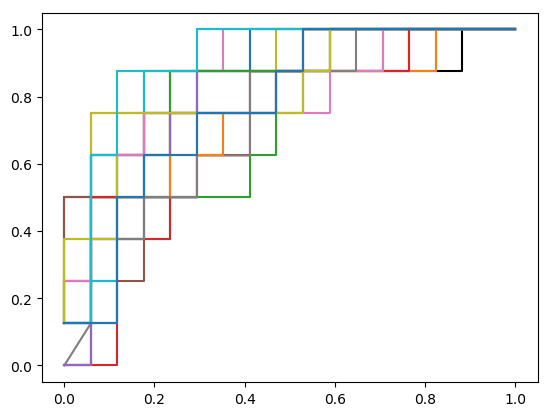

In [39]:
plot(fpr,tpr, color="black")
for i in 1:21
     plot(fpr2_was[i], tpr2_was[i])
end

In [40]:
# Montrer pour différente de taille de dataset et regarder à partir de quel moment la méthode de base décroche

In [41]:
print(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
for i in 1:21
    print(roc_auc_score(df_aux[:,end], positive_rate(xr1_was[i],df_aux)))
    print("  ")
    println(accuracy_score(df_aux[:,end], pred(df_aux, xr1_was[i], LogisticRegression())))
end

0.8308823529411764  0.64
0.7867647058823529  0.64
0.7720588235294117  0.64
0.7058823529411764  0.56
0.6911764705882353  0.6
0.8308823529411764  0.68
0.8602941176470588  0.64
0.838235294117647  0.76
0.7683823529411764  0.64
0.8897058823529411  0.68
0.8529411764705882  0.72
0.8529411764705882  0.72
0.75  0.6
0.8382352941176471  0.8
0.7941176470588236  0.64
0.8455882352941175  0.68
0.75  0.64
0.7794117647058822  0.72
0.75  0.64
0.8161764705882353  0.56
0.9044117647058822  0.76
0.7720588235294118  0.64


In [42]:
print(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
for i in 1:21
    print(roc_auc_score(df_aux[:,end], positive_rate(xr2_was[i],df_aux)))
    print("  ")
    println(accuracy_score(df_aux[:,end], pred(df_aux, xr2_was[i], LogisticRegression())))
end

0.8308823529411764  0.64
0.7794117647058824  0.64
0.7720588235294117  0.64
0.7058823529411764  0.56
0.6911764705882353  0.6
0.8308823529411764  0.68
0.8602941176470588  0.64
0.838235294117647  0.76
0.7683823529411764  0.64
0.8897058823529411  0.68
0.8529411764705882  0.72
0.8529411764705882  0.72
0.75  0.6
0.8382352941176471  0.8
0.786764705882353  0.64
0.8455882352941175  0.68
0.75  0.64
0.7794117647058822  0.72
0.75  0.64
0.8161764705882353  0.56
0.9044117647058822  0.76
0.7720588235294118  0.64


In [43]:
println(classification_report(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
println(classification_report(df_aux[:,end], pred(df_aux, xr1_was[3], LogisticRegression())))

             precision    recall  f1-score   support

       -1.0       0.90      0.53      0.67        17
        1.0       0.47      0.88      0.61         8

avg / total       0.76      0.64      0.65        25

             precision    recall  f1-score   support

       -1.0       0.75      0.53      0.62        17
        1.0       0.38      0.62      0.48         8

avg / total       0.63      0.56      0.57        25



In [ ]:
N = size(df_train)[1]
verbosity = 1
itmax = 2000
sample = 100

ambiguity = "entropic"
robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
α = 1/norm(robustModel.descent_direction)

projParams = ProjParams(Int(40), 1e-5, sample, para_proj=Sequential(), para_inter=Sequential())
optParams = OptParams(itmax, 1e-5, α, verbosity = verbosity);

In [ ]:
robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
x0 = x0 = initialize(df_train, robustModel, EntropicConstraint())
xalg, yalg, dm, mem, mini = run_algo(x0, df_train, robustModel, optParams, projParams)
xrobust1 = getsolution(xalg, ambiguity, nbfeatures)
xrobust2 = getsolution(mem, ambiguity, nbfeatures)
fpr1_ent, tpr1_ent, thresholds_ent = roc_curve(df_aux[:,end], positive_rate(xrobust1,df_aux))
fpr2_ent, tpr2_ent, thresholds_ent = roc_curve(df_aux[:,end], positive_rate(xrobust2,df_aux))

In [ ]:
plot(dm)

In [ ]:
plot(fpr,tpr, color="black")
plot(fpr1_ent, tpr1_ent)

In [ ]:
plot(fpr,tpr, color="black")
plot(fpr2_ent, tpr2_ent)

In [ ]:
print(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
print(roc_auc_score(df_aux[:,end],positive_rate(xrobust1,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xrobust1, LogisticRegression())))
print(roc_auc_score(df_aux[:,end],positive_rate(xrobust2,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xrobust2, LogisticRegression())))

In [ ]:
println(classification_report(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))

In [ ]:
println(classification_report(df_aux[:,end], pred(df_aux, xrobust1, LogisticRegression())))

In [ ]:
println(classification_report(df_aux[:,end], pred(df_aux, xrobust2, LogisticRegression())))

In [ ]:
pred(df_aux, xrobust2, LogisticRegression())

In [44]:
open("colon-opt.txt", "w") do f
    write(f, "xnormal = ")
    write(f, "$xnormal \n")
    write(f, "fpr = ")
    write(f, "$fpr \n")
    write(f, "tpr = ")
    write(f, "$tpr \n")
    write(f, "dm_tab = ")
    write(f, "$dm_tab \n")
    write(f, "xr1_tab = ")
    write(f, "$xr1_tab \n")
    write(f, "fpr1_tab = ")
    write(f, "$fpr1_tab \n")
    write(f, "tpr1_tab = ")
    write(f, "$tpr1_tab \n")
    write(f, "dm_was = ")
    write(f, "$dm_was \n")
    write(f, "xr1_was = ")
    write(f, "$xr1_was \n")
    write(f, "fpr1_was = ")
    write(f, "$fpr1_was \n")
    write(f, "tpr1_was = ")
    write(f, "$tpr1_was \n")
#     write(f, "dm = ")
#     write(f, "$dm \n")
#     write(f, "xrobuts1 = ")
#     write(f, "$xrobuts1 \n")
#     write(f, "fpr1_ent = ")
#     write(f, "$fpr1_ent \n")
#     write(f, "tpr1_ent = ")
#     write(f, "$tpr1_ent \n")
end

1445